In [1]:
import json
from notebooks.util import make_best_flow_kwargs_col
import pandas as pd

decimal_precision = 2

with open("../results.json", 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data['general_experiment'])
df['flow_kwargs'] = df['flow_kwargs'].map(str)
df['best_kwargs'] = make_best_flow_kwargs_col(df)

In [2]:
from util import standardized_rank
from util import get_standard_flow_order, get_standard_sampler_order

_sr_sampler = standardized_rank(
    df[df['best_kwargs']],
    rank_what=['sampler'],
    rank_across=['benchmark'],
    metric='second_moment_squared_bias'
).reset_index()

order = get_standard_sampler_order(_sr_sampler['sampler'])[::-1]
_sr_sampler = _sr_sampler.iloc[order].reset_index().drop('index', axis=1)
_sr_sampler

,sampler,mean_rank,sem_rank
0,neutra_hmc,-0.055556,0.209609
1,jump_hmc,-0.805556,0.206665
2,hmc,-0.833333,0.166667
3,neutra_mh,0.472222,0.178374
4,jump_mh,-0.361111,0.170570
5,imh,0.333333,0.134067
6,mh,1.250000,0.141479


In [3]:
_sr_sampler_best = standardized_rank(
    df,
    rank_what=['sampler'],
    rank_across=['benchmark'],
    metric='second_moment_squared_bias',
    summary='min'
).reset_index()

order = get_standard_sampler_order(_sr_sampler_best['sampler'])[::-1]
_sr_sampler_best = _sr_sampler_best.iloc[order].reset_index().drop('index', axis=1)
_sr_sampler_best

,sampler,mean_rank,sem_rank
0,neutra_hmc,-0.166667,0.134067
1,jump_hmc,-1.194444,0.181402
2,hmc,-0.138889,0.165711
3,neutra_mh,0.500000,0.166667
4,jump_mh,-0.277778,0.210905
5,imh,-0.166667,0.166667
6,mh,1.444444,0.055556


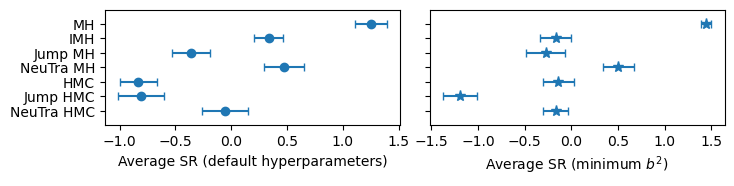

In [4]:
import matplotlib.pyplot as plt
from util import SAMPLER_PRETTY

fig, axes = plt.subplots(1, 2, figsize=(8, 1.5), sharey=True)

for index, row in _sr_sampler.iterrows():
    axes[0].errorbar(x=row['mean_rank'], y=index, xerr=row['sem_rank'], capsize=3, c='tab:blue', marker='o')

for index, row in _sr_sampler_best.iterrows():
    axes[1].errorbar(x=row['mean_rank'], y=index, xerr=row['sem_rank'], capsize=3, c='tab:blue', marker='*',
                     markersize=2 ** 3)

axes[0].set_yticks(_sr_sampler.index, [SAMPLER_PRETTY[s] for s in _sr_sampler['sampler']])
axes[0].set_xlabel('Average SR (default hyperparameters)')
axes[1].set_xlabel('Average SR (minimum $b^2$)')

# axes[1].set_yticks([])

axes[0].set_ylim(-1, len(_sr_sampler.index))

fig.subplots_adjust(wspace=0.1)

fig.savefig('images/nfmc-all-benchmarks.png', bbox_inches='tight', dpi=600)
fig.savefig('images/nfmc-all-benchmarks.pdf', bbox_inches='tight')

plt.show()

In [5]:
from util import get_benchmark_family

df['benchmark_family'] = [get_benchmark_family(b) for b in df['benchmark']]

In [6]:
# table with NF kwargs that give you the minimum b2
import numpy as np

masks = [
            (df['benchmark_family'] == f) for f in
            ['gaussian', 'non-gaussian (curved)', 'multimodal', 'non-gaussian (hierarchical)']
        ] + [
            pd.Series(np.ones(df.shape[0], dtype=bool))
        ]

tmp = pd.concat([
    standardized_rank(
        df[m],
        rank_what='sampler',
        rank_across='benchmark',
        summary='min'
    ).apply(lambda el: round(el, decimal_precision)).apply(tuple, axis=1)
    for m in masks
], axis=1)
tmp.columns = ['Gaussian', 'Non-Gaussian', 'Multimodal', 'Hierarchical', 'All']

order = get_standard_sampler_order([e[0] for e in tmp.index])
tmp = tmp.iloc[order]
tmp.index = [SAMPLER_PRETTY[s] for (s,) in tmp.index]

tmp = tmp.reset_index()
tmp.columns = ['Sampler'] + list(tmp.columns)[1:]

In [7]:
from util import to_booktabs_table, make_bold_mask

to_booktabs_table(
    tmp,
    bold_mask=make_bold_mask(
        tmp.set_index('Sampler'),
        top_quantile=1.0,
    ), save_to_file='tables/nfmc-per-family.tex',
    caption=r'$\overline{r} \pm \hat{\sigma}$ for all samplers and target families. Samplers with the best $\overline{r}$ are shown in bold for each target family. We estimate $\overline{r} \pm \hat{\sigma}$ with the minimum $b^2$ across all NFs for each target within a family. Entries without $\hat{\sigma}$ always attain the same $\overline{r}$. Ranks computed separately for each target family.',
    label='tab:nfmc-per-family'
)

\begin{table}

            \renewrobustcmd{\bfseries}{\fontseries{b}\selectfont}
            \renewrobustcmd{\boldmath}{}
            \sisetup{%
                table-align-uncertainty=true,
                detect-all,
                separate-uncertainty=true,
                mode=text,
                round-mode=uncertainty,
                round-precision=2,
                table-format = 2.2(2),
                table-column-width=2.1cm
            }
            
\begin{tabular}{l
S
S
S
S
S}
\toprule
{Sampler} & {Gaussian} & {Non-Gaussian} & {Multimodal} & {Hierarchical} & {All} \\
\midrule
{MH} & 1.5 & 1.5 & 1.5 & 1.38(0.12) & 1.44(0.06) \\
{IMH} & 0.38(0.47) & 0.00(0.50) & 0.25(0.25) & -0.69(0.09) & -0.17(0.17) \\
{Jump MH} & -0.50(0.29) & \bfseries -1.25(0.25) & -0.75(0.32) & 0.31(0.31) & -0.28(0.21) \\
{NeuTra MH} & 0.75(0.14) & 1.0 & 0.50(0.50) & 0.25(0.27) & 0.50(0.17) \\
{HMC} & -0.62(0.12) & 0.00(0.50) & -0.12(0.43) & 0.06(0.27) & -0.14(0.17) \\
{Jump HMC} & \bfseries -1.5 &

In [8]:
# Same df but for flows

# table with default NF kwargs
import numpy as np
from util import to_booktabs_table, FLOW_PRETTY_MATH, make_bold_mask

masks = [
            (df['benchmark_family'] == f).values for f in
            ['gaussian', 'non-gaussian (curved)', 'multimodal', 'non-gaussian (hierarchical)']
        ] + [
            pd.Series(np.ones(df.shape[0], dtype=bool)).values
        ]

masks = [m & (df['flow'] != 'None') for m in masks]

In [9]:
jump_mcmc_mask = (~df['sampler'].isin(['neutra_mh', 'neutra_hmc']))

tmp_jump = pd.concat([
    standardized_rank(
        df[(m & jump_mcmc_mask) & (df['best_kwargs'])],
        rank_what='flow',
        rank_across='benchmark'
    ).apply(lambda el: round(el, decimal_precision)).apply(tuple, axis=1)
    for m in masks
], axis=1)
tmp_jump.columns = ['Gaussian', 'Non-Gaussian', 'Multimodal', 'Hierarchical', 'All']

order = get_standard_flow_order([f for f, in tmp_jump.index])
tmp_jump = tmp_jump.iloc[order]
tmp_jump.index = [FLOW_PRETTY_MATH[s] for (s,) in tmp_jump.index]

bold_mask = make_bold_mask(tmp_jump, top_quantile=0.8)
tmp_jump = tmp_jump.reset_index()
tmp_jump.columns = ['NF'] + list(tmp_jump.columns)[1:]

to_booktabs_table(
    tmp_jump,
    bold_mask=bold_mask,
    save_to_file='tables/nf-per-family.tex',
    caption=r'$\overline{r} \pm \hat{\sigma}$ for all NFs and target families in IMH, Jump MH, and Jump HMC. NFs in the top 20th percentile are shown in bold for each target family. We estimate $\overline{r} \pm \hat{\sigma}$ with $b^2$ from runs with default hyperparameters. Entries without $\hat{\sigma}$ always attain the same $\overline{r}$. Ranks computed separately for each target family.',
    label='tab:nf-per-family'
)

\begin{table}

            \renewrobustcmd{\bfseries}{\fontseries{b}\selectfont}
            \renewrobustcmd{\boldmath}{}
            \sisetup{%
                table-align-uncertainty=true,
                detect-all,
                separate-uncertainty=true,
                mode=text,
                round-mode=uncertainty,
                round-precision=2,
                table-format = 2.2(2),
                table-column-width=2.1cm
            }
            
\begin{tabular}{l
S
S
S
S
S}
\toprule
{NF} & {Gaussian} & {Non-Gaussian} & {Multimodal} & {Hierarchical} & {All} \\
\midrule
{NICE} & -0.43(0.31) & 1.45(0.14) & \bfseries -0.80(0.25) & 0.00(0.32) & -0.11(0.22) \\
{Real NVP} & \bfseries -0.80(0.25) & \bfseries -1.16(0.43) & 0.29(0.36) & 0.29(0.32) & -0.11(0.22) \\
{C-LR-NSF} & -0.14(0.72) & 0.72(0.58) & \bfseries -0.51(0.30) & -0.40(0.19) & -0.24(0.20) \\
{C-RQ-NSF} & \bfseries -0.87(0.19) & 1.01 & \bfseries -0.51(0.38) & 0.43(0.39) & 0.00(0.24) \\
{C-NAF$_\mathrm{deep}$} & 

In [10]:
jump_mcmc_mask = (~df['sampler'].isin(['neutra_mh', 'neutra_hmc']))

tmp_neutra = pd.concat([
    standardized_rank(
        df[m & (~jump_mcmc_mask) & df['best_kwargs']],
        rank_what='flow',
        rank_across='benchmark'
    ).apply(lambda el: round(el, decimal_precision)).apply(tuple, axis=1)
    for m in masks
], axis=1)
tmp_neutra.columns = ['Gaussian', 'Non-Gaussian', 'Multimodal', 'Hierarchical', 'All']

order = get_standard_flow_order([f for f, in tmp_neutra.index])
tmp_neutra = tmp_neutra.iloc[order]
tmp_neutra.index = [FLOW_PRETTY_MATH[s] for (s,) in tmp_neutra.index]

bold_mask = make_bold_mask(tmp_neutra, top_quantile=0.8)
tmp_neutra = tmp_neutra.reset_index()
tmp_neutra.columns = ['NF'] + list(tmp_neutra.columns)[1:]

to_booktabs_table(
    tmp_neutra,
    bold_mask=bold_mask,
    save_to_file='tables/nf-per-family-neutra.tex',
    caption=r'$\overline{r} \pm \hat{\sigma}$ for all NFs and target families in NeuTra MH and NeuTra HMC. NFs in the top 20th percentile are shown in bold for each target family. We estimate $\overline{r} \pm \hat{\sigma}$ with $b^2$ from runs with default hyperparameters. Entries without $\hat{\sigma}$ always attain the same $\overline{r}$. Ranks computed separately for each target family.',
    label='tab:nf-per-family-neutra',
)

\begin{table}

            \renewrobustcmd{\bfseries}{\fontseries{b}\selectfont}
            \renewrobustcmd{\boldmath}{}
            \sisetup{%
                table-align-uncertainty=true,
                detect-all,
                separate-uncertainty=true,
                mode=text,
                round-mode=uncertainty,
                round-precision=2,
                table-format = 2.2(2),
                table-column-width=2.1cm
            }
            
\begin{tabular}{l
S
S
S
S
S}
\toprule
{NF} & {Gaussian} & {Non-Gaussian} & {Multimodal} & {Hierarchical} & {All} \\
\midrule
{NICE} & 0.21(0.42) & 1.07(0.25) & 0.62(0.38) & -0.31(0.27) & 0.17(0.20) \\
{Real NVP} & 0.17(0.32) & 1.57(0.08) & 0.83(0.29) & 0.52(0.37) & 0.62(0.21) \\
{C-LR-NSF} & -0.62(0.42) & 0.33(0.33) & -0.37(0.49) & 0.20(0.32) & -0.10(0.21) \\
{C-RQ-NSF} & \bfseries -0.87(0.33) & 0.33(0.17) & -0.04(0.25) & \bfseries -0.45(0.33) & -0.36(0.18) \\
{C-NAF$_\mathrm{deep}$} & 1.07(0.08) & 0.50(0.17) & 1.40(0.11) &